This program contains suggestions on whether to buy or sell a stock based on the technicals and some machine learning predictions. I haven't some aspects of this program, so don't make judgements as to buy or sell a stock based solely on the signals outputed. USE SIGNALS AS ONLY SUGGESTIONS

In [1]:
!pip install yfinance

  Created wheel for yfinance: filename=yfinance-0.1.54-py2.py3-none-any.whl size=22409 sha256=2e43f72c35319831a4270e5b58b6871a972c3edad8495fe15f64e355f6a55949
  Stored in directory: /root/.cache/pip/wheels/f9/e3/5b/ec24dd2984b12d61e0abf26289746c2436a0e7844f26f2515c
Successfully built yfinance


In [2]:
#libraries
import pandas as pd 
import math
import numpy as np
from datetime import datetime

from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override
from datetime import datetime
import numpy as np
import pandas_datareader as web
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [60]:
def plotog(df):
  plt.figure(figsize=(12.2, 4.5))
  plt.title('Close Price History')
  plt.plot(df['Close'], color = 'blue', alpha = 0.35)
  plt.xlabel('Date', fontsize = 18)
  plt.ylabel('Close Price', fontsize = 18)
  plt.show()

In [61]:
#dma
def buy_selldma(data):
  sigPricebuy = []
  sigPricesell = []
  flag = -1

  for i in range (len(data)):
    if data['SMA30'][i] > data['SMA100'][i]: 
      if flag !=1:
        sigPricebuy.append(data['df'][i])
        sigPricesell.append(np.nan)
        flag = 1 
      else: 
       sigPricebuy.append(np.nan)
       sigPricesell.append(np.nan)
    elif data['SMA30'][i] < data['SMA100'][i]:
      if flag != 0:
        sigPricebuy.append(np.nan)
        sigPricesell.append(data['df'][i])
        flag = 0
      else:
        sigPricesell.append(np.nan)
        sigPricebuy.append(np.nan)
    else: 
      sigPricebuy.append(np.nan)
      sigPricesell.append(np.nan)


  return (sigPricebuy, sigPricesell)

def dmaplots(data):
  plt.figure(figsize=(12.6, 4.6))
  plt.plot(data['df'], alpha = 0.35)
  plt.plot(data['SMA30'], label ='SMA30', alpha = 0.35 )
  plt.plot(data['SMA100'], label = 'SMA100', alpha = 0.35)
  plt.scatter(data.index, data['Buy'], label = 'Buy', marker= '^', color = 'green')
  plt.scatter(data.index, data['Sell'], label = 'Sell', marker= 'v', color = 'red')
  plt.title('Dual Moving Average')
  plt.xlabel('Date')
  plt.xticks(rotation=45)
  plt.ylabel('Price')
  plt.legend(loc = 'lower left')
  plt.show()



def dma(df):
  SMA30=pd.DataFrame()
  SMA30['Close'] = df['Close'].rolling(window=30).mean()
  #SMA30
  SMA100=pd.DataFrame()
  SMA100['Close'] = df['Close'].rolling(window=100).mean()
  #SMA100
  data = pd.DataFrame()
  data['df'] = df['Close']
  data['SMA30'] = SMA30['Close']
  data['SMA100'] = SMA100['Close']
  #data
  a = buy_selldma(data)
  data['Buy'] = a[0]
  data['Sell'] = a[1]
  dmaplots(data)
  
  print(data.tail(5)[['Buy', 'Sell']])

In [62]:
#macd
def buy_sellmacd(signal):
  Buy=[]
  Sell=[]
  flag= -1
  
  for i in range(0, len(signal)):
    if signal['MACD'][i] > signal['Signal Line'][i]: 
      Sell.append(np.nan)
      if flag != 1:
        Buy.append(signal['Close'][i])
        flag =1 
      else: 
        Buy.append(np.nan)
    elif signal['MACD'][i] < signal['Signal Line'][i]: 
      Buy.append(np.nan)
      if flag != 0:
        Sell.append(signal['Close'][i])
        flag = 0 
      else: 
        Sell.append(np.nan)
    else:
      Buy.append(np.nan)
      Sell.append(np.nan)

  return(Buy, Sell) 

def macdPlot(df):
  #visually show buy and sell signals
  plt.figure(figsize=(12.6, 4.6))
  plt.scatter(df.index, df['Buy'], label='Buy', marker='^', alpha =1)
  plt.scatter(df.index, df['Sell'], label='Sell', marker='v', alpha =1)
  plt.plot(df['Close'], label='Close Price', alpha =0.35)
  plt.title("MACD")
  plt.xticks(rotation=45)
  plt.xlabel('Date')
  plt.ylabel('Price')
  plt.legend(loc = 'lower left')
  plt.show()

def fnMacd(df):
  #calculations for macd and signal line
  #calculate short term exonential moving average (ema)
  ShortEMA = df.High.ewm(span=12, adjust=False).mean()#short term last 12periods usually
  #calculate longer term exponential moving average
  LongEMA= df.High.ewm(span=26, adjust=False).mean()#long term last 26periods
  #calculate the macd line
  MACD = ShortEMA - LongEMA
  #Calculate Signal LIne
  signal = MACD.ewm(span=9, adjust=False).mean()

  df['MACD'] = MACD
  df['Signal Line'] = signal
  #print(df)

  #create buy and sell column
  a = buy_sellmacd(df)
  df['Buy'] = a[0]
  df['Sell'] = a[1]
  macdPlot(df)

  print(df.tail(5)[['Buy', 'Sell']])

In [63]:
#rsi
def rsidata(df):
  delta = df['Close'].diff(1) #difference in price from previous day
  delta = delta.dropna()
  up = delta.copy()
  down = delta.copy() 

  up[up<0] = 0 
  down[down>0] = 0
  period = 14
  #calculate the average gain and average loss
  avg_gain = up.rolling(window=period).mean()
  avg_loss=abs(down.rolling(window=period).mean())
  rs = avg_gain/avg_loss

  #calculate relative strength index for rsi 
  rsi = 100.0 - (100.0/ (1.0 + rs))

  new_df = pd.DataFrame()
  new_df['Close'] = df['Close']
  new_df['RSI'] = rsi
  

  #visually show the adj close price and rsi 
# plot the adj close price 

 
  #plot the correspodning rsi values and significant level
  plt.figure(figsize=(12.6, 4.6))
  plt.title('RSI Plot')
  plt.plot(new_df['RSI'])
  plt.axhline(0, linestyle='-', alpha = 0.5, color ='gray')
  plt.axhline(10, linestyle='-', alpha = 0.5, color ='orange')
  plt.axhline(20, linestyle='-', alpha = 0.5, color ='green')
  plt.axhline(30, linestyle='-', alpha = 0.5, color ='red')
  plt.axhline(70, linestyle='-', alpha = 0.5, color ='red')
  plt.axhline(80, linestyle='-', alpha = 0.5, color ='green')
  plt.axhline(90, linestyle='-', alpha = 0.5, color ='orange')
  plt.axhline(100, linestyle='-', alpha = 0.5, color ='gray')
  plt.show()

In [64]:
#3ma
def buy_sell_function(data):
  
  buy_list=[]
  sell_list=[]
  flag_long = False
  flag_short = False

  for i in range(0, len(data)):
    if data['Middle'][i] < data['Long'][i] and data['Short'][i] < data['Middle'][i] and flag_long == False and flag_short == False:
      buy_list.append(data['Close'][i]) 
      sell_list.append(np.nan)
      flag_short = True
    elif flag_short == True and data['Short'][i] > data['Middle'][i]:
      sell_list.append(data['Close'][i])
      buy_list.append(np.nan)
      flag_short = False
    elif data['Middle'][i] > data['Long'][i] and data['Short'][i] > data['Middle'][i] and flag_long == False and flag_short == False:
      buy_list.append(data['Close'][i]) 
      sell_list.append(np.nan)
      flag_long = True
    elif flag_long == True and data['Short'][i] < data['Middle'][i]:
      sell_list.append(data['Close'][i])
      buy_list.append(np.nan)
      flag_long = False
    else: 
      buy_list.append(np.nan)
      sell_list.append(np.nan)
  
  return(buy_list, sell_list)

def threema(df): 
  ShortEMA = df.Close.ewm(span=5, adjust = False).mean()
  #calculate the middle/medium exponential moving average
  MiddleEMA = df.Close.ewm(span=34, adjust = False).mean() #change span to 21
  #calculate the long/slow exponential moving average 
  LongEMA= df.Close.ewm(span=63, adjust = False).mean() 

  df['Short'] = ShortEMA
  df['Middle'] = MiddleEMA
  df['Long'] = LongEMA
  df['Buy'] = buy_sell_function(df)[0]
  df['Sell'] = buy_sell_function(df)[1]


  plt.figure(figsize=(12.2, 4.5))
  plt.title('Three Moving Averages')
  plt.plot(df['Close'], color = 'blue', alpha = 0.35)
  plt.plot(ShortEMA, label = 'Short EMA', color = 'red', alpha = 0.35)
  plt.plot(MiddleEMA, label = 'Middle EMA', color = 'orange', alpha = 0.35)
  plt.plot(LongEMA, label = 'Long EMA', color = 'green', alpha = 0.35)
  plt.scatter(df.index, df['Buy'], color = 'green', marker = '^', alpha = 1)
  plt.scatter(df.index, df['Sell'], color = 'red', marker = 'v', alpha = 1)
  plt.xlabel('Date', fontsize = 18)
  plt.ylabel('Close Price', fontsize = 18)
  plt.legend(loc = 'lower left')
  plt.show()

  print(df.tail(5)[['Buy', 'Sell']])

[*********************100%***********************]  1 of 1 completed
BIOC



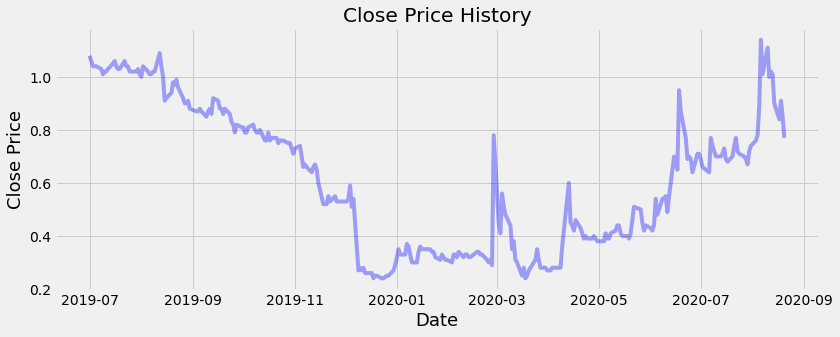

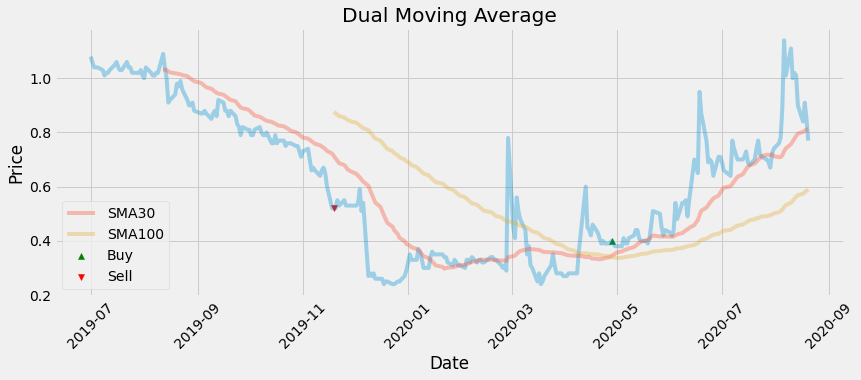

            Buy  Sell
Date                 
2020-08-14  NaN   NaN
2020-08-17  NaN   NaN
2020-08-18  NaN   NaN
2020-08-19  NaN   NaN
2020-08-20  NaN   NaN



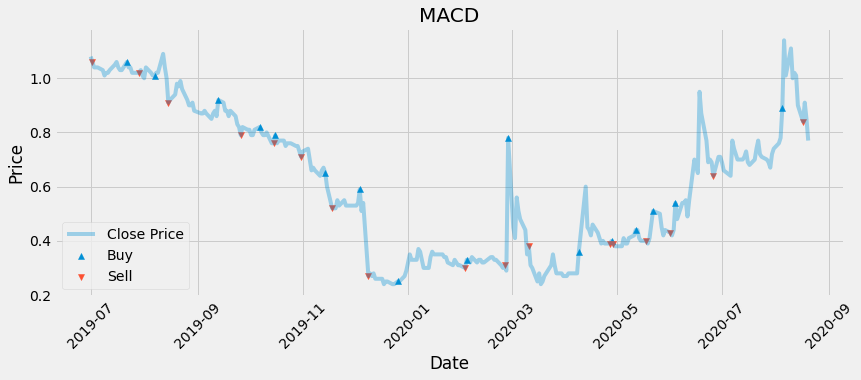

            Buy  Sell
Date                 
2020-08-14  NaN   NaN
2020-08-17  NaN  0.84
2020-08-18  NaN   NaN
2020-08-19  NaN   NaN
2020-08-20  NaN   NaN



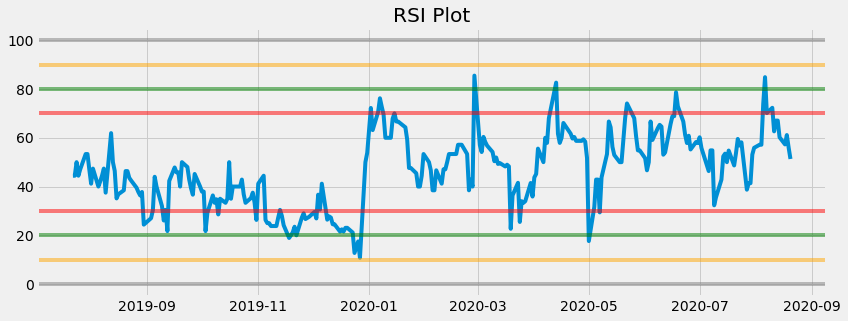

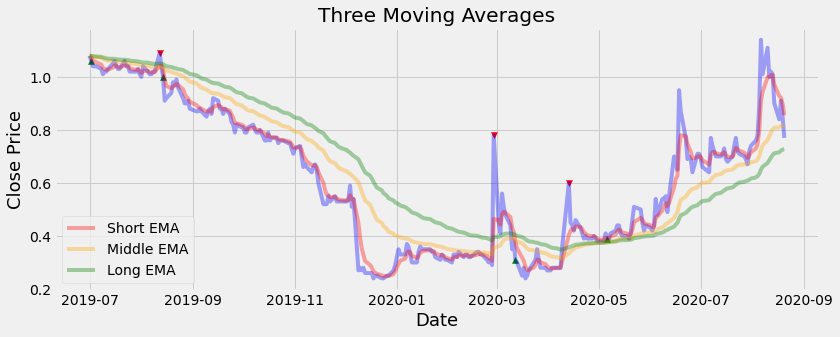

            Buy  Sell
Date                 
2020-08-14  NaN   NaN
2020-08-17  NaN   NaN
2020-08-18  NaN   NaN
2020-08-19  NaN   NaN
2020-08-20  NaN   NaN
[*********************100%***********************]  1 of 1 completed
MYOS



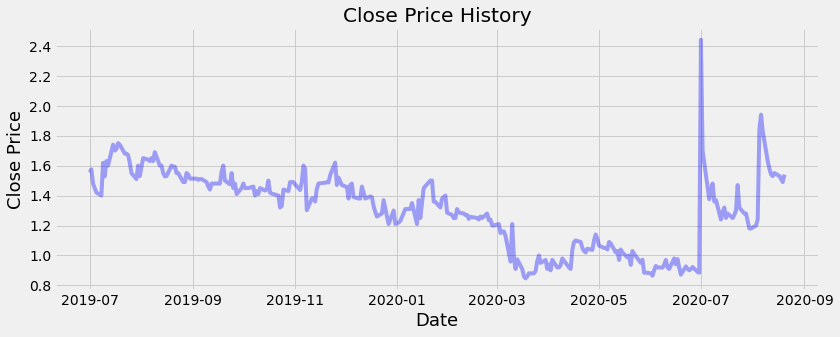

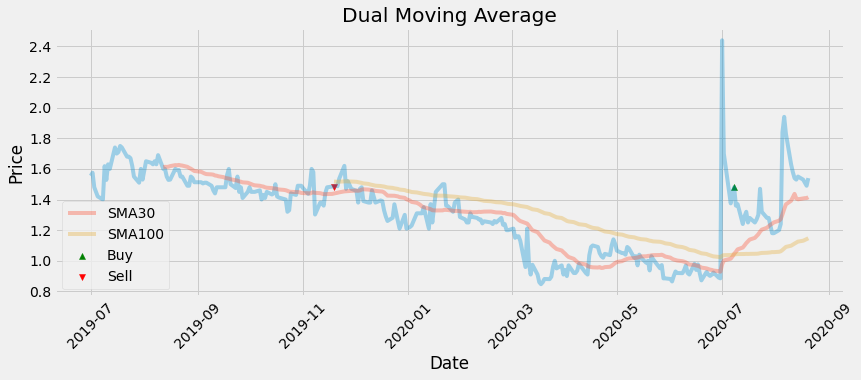

            Buy  Sell
Date                 
2020-08-14  NaN   NaN
2020-08-17  NaN   NaN
2020-08-18  NaN   NaN
2020-08-19  NaN   NaN
2020-08-20  NaN   NaN



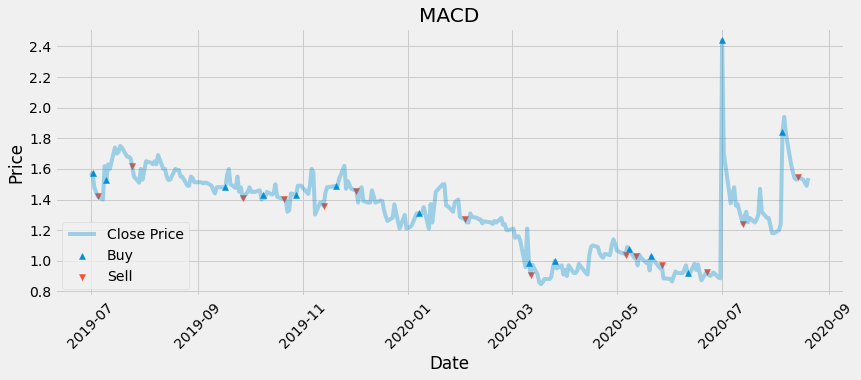

            Buy  Sell
Date                 
2020-08-14  NaN  1.55
2020-08-17  NaN   NaN
2020-08-18  NaN   NaN
2020-08-19  NaN   NaN
2020-08-20  NaN   NaN



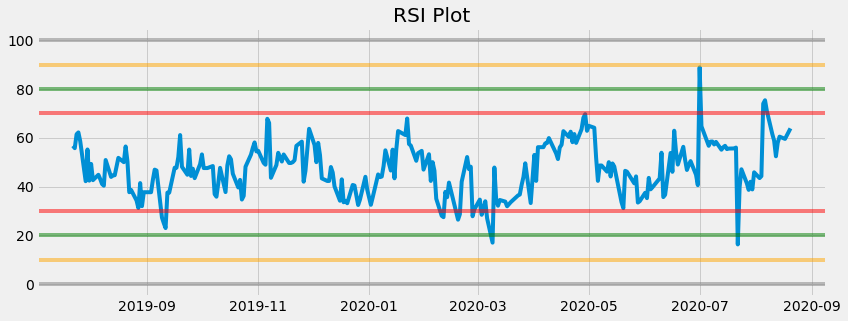

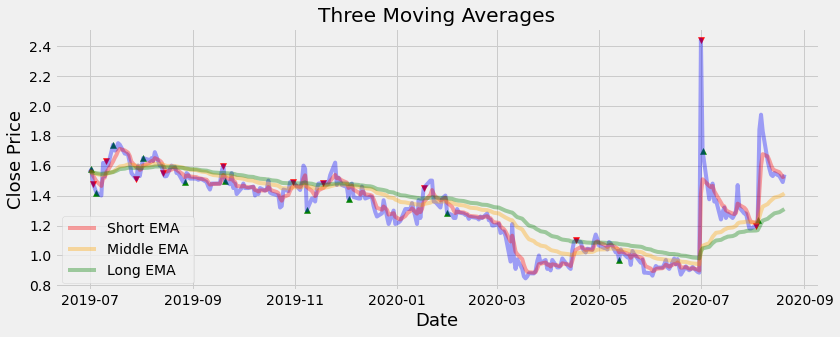

            Buy  Sell
Date                 
2020-08-14  NaN   NaN
2020-08-17  NaN   NaN
2020-08-18  NaN   NaN
2020-08-19  NaN   NaN
2020-08-20  NaN   NaN
[*********************100%***********************]  1 of 1 completed
IDEX



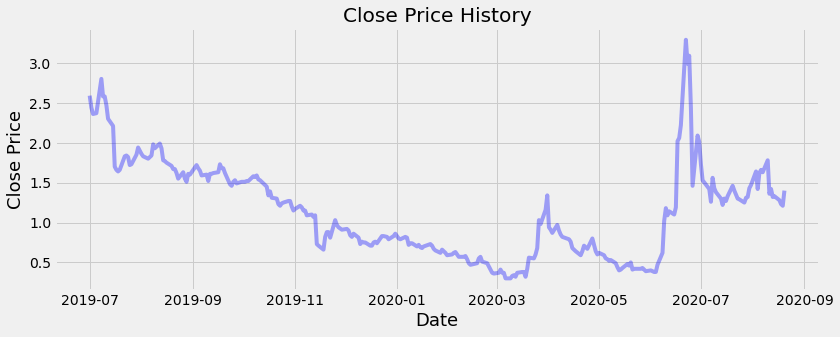

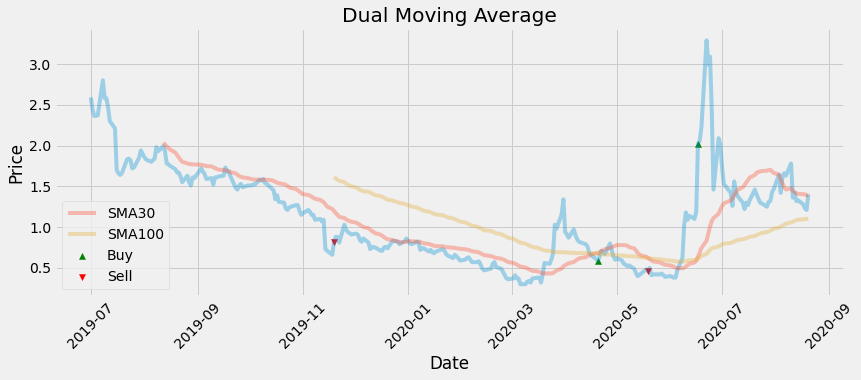

            Buy  Sell
Date                 
2020-08-14  NaN   NaN
2020-08-17  NaN   NaN
2020-08-18  NaN   NaN
2020-08-19  NaN   NaN
2020-08-20  NaN   NaN



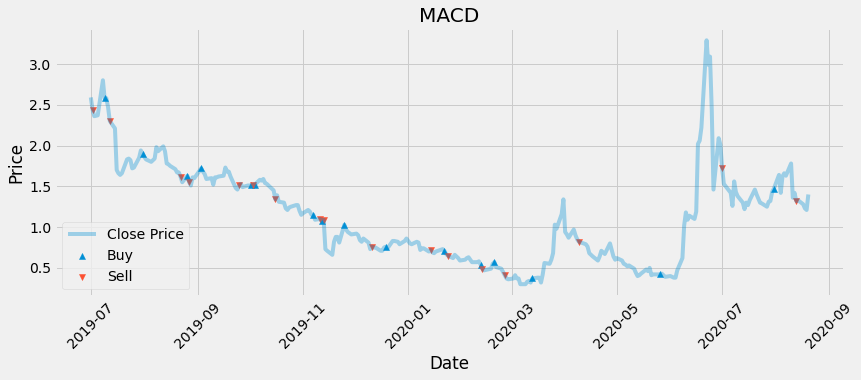

            Buy  Sell
Date                 
2020-08-14  NaN   NaN
2020-08-17  NaN   NaN
2020-08-18  NaN   NaN
2020-08-19  NaN   NaN
2020-08-20  NaN   NaN



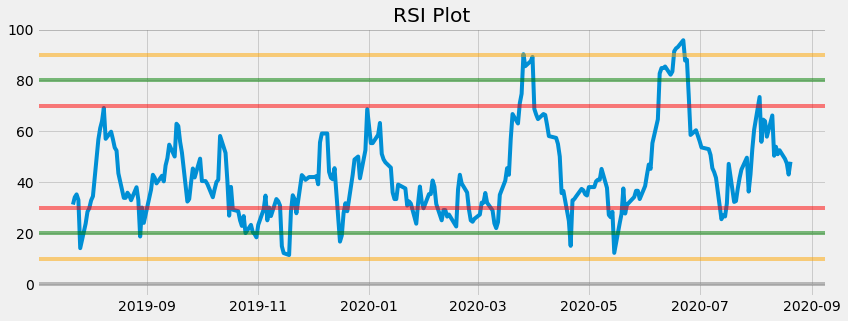

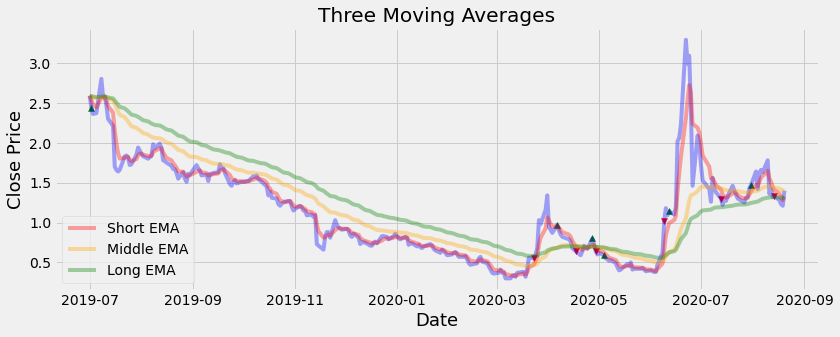

            Buy  Sell
Date                 
2020-08-14  NaN  1.33
2020-08-17  NaN   NaN
2020-08-18  NaN   NaN
2020-08-19  NaN   NaN
2020-08-20  NaN   NaN


In [65]:
today = datetime.today().strftime('%Y-%m-%d')
ticks = ["BIOC", "MYOS","IDEX"]#, "KTOV", "PBTS", "ALRN", "CLNE", "MRNS", "ATHE", "MICT", "TEDU", "F"]
for i in ticks:
  tickerDf = yf.download(i, interval='1d', start='2019-7-1', end=today)
  df = pd.DataFrame(tickerDf)
  print(i)
  print()
  plotog(df)
  print()
  dma(df)
  print()
  fnMacd(df)
  print()
  threema(df)
  print()
  rsidata(df)

In [71]:
def dataltsm(df):
  data = df.filter(['Close'])
  #Convert Dataframe to numpy array
  dataset = data.values
  #get number of rows to train the model on
  training_data_len = math.ceil(len(dataset)*.8)
  #print(training_data_len)

  scaler = MinMaxScaler(feature_range=(0,1))
  scaled_data = scaler.fit_transform(dataset)
  #print(scaled_data)

  train_data = scaled_data[0:training_data_len , :]
  #Split DAta into x_train and y_train data sets 
  x_train =[]
  y_train =[]
  for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<=61:
      #print(x_train)
      #print(y_train)
      print()

  x_train, y_train =np.array(x_train), np.array(y_train)
  x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
  x_train.shape

  model = Sequential()
  model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1],1)))
  model.add(LSTM(50, return_sequences=False))
  model.add(Dense(25))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mean_squared_error')

  model.fit(x_train, y_train, batch_size=1, epochs=1)

  test_data = scaled_data[training_data_len - 60: , :]
  #create data sets x_test and y_test
  x_test = []
  y_test = dataset[training_data_len:, :] #test values
  for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

  x_test = np.array(x_test)

  x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

  predictions = model.predict(x_test)
  predictions = scaler.inverse_transform(predictions)

  #rmse = np.sqrt(np.mean(((predictions - y_test)**2)))
  #rmse

  train = data [:training_data_len]
  valid = data[training_data_len:]
  #valid['Predictions'] = predictions
  #print(valid)

  #end date 4 means predicting for 5
  new_df = df.filter(['Close'])
  #get the last 60 day closing day values and convert df to array
  datasets = new_df.values
  scaler = MinMaxScaler(feature_range=(0,1))
  scaled_data = scaler.fit_transform(datasets)
  last_60_days= new_df[-60:].values
  #scale the data to be values between 0 and 1
  last_60_days_scaled=scaler.transform(last_60_days)
  #create an empty list
  X_test = []
  #append the past 60 days to the X_test
  X_test.append(last_60_days_scaled) 
  #conver the X_test data set to numpy array
  X_test=np.array(X_test)
  #reshape the data
  X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
  #get predicted price
  pred_price = model.predict(X_test)
  #undo scaling
  pred_price = scaler.inverse_transform(pred_price)
  print("The LTSM Model Predicts Next Price Will Be", pred_price)
  


In [77]:
def pred1(df):

  forecast_out = 1 #predicting only one day out into future

  df = df[['Close']]
  df['Prediction'] = df[['Close']].shift(-forecast_out) #shifitng data "forecast" days back, so (today-'forecast') will have no value in prediciton column 

  #independent data set
  X = np.array(df.drop(['Prediction'],1))
  #remove the last 'n' rows 
  X = X[: -forecast_out] #remove this line of code for future 

  #conver the df to numpy array, dependent data set
  y = np.array(df['Prediction'])
  #get all y-values, except last 'forecast_out' rows, remove this line
  y= y[:-forecast_out]


  x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2 ) #0.2 means training on 80% testing on 20%

  #create and train the support vector machine (Regression)
  svr_rbf = SVR(kernel ='rbf', C=1.0, gamma=0.1)
  svr_rbf.fit(x_train, y_train)

  svm_confidence = svr_rbf.score(x_test, y_test)
  print('svm_confidence: ', svm_confidence)

  #create and train the linear regression model 
  lr = LinearRegression()
  #train model
  lr.fit(x_train, y_train)


  lr_confidence = lr.score(x_test, y_test)
  print('lr_confidence: ', lr_confidence)
  print()

  #set variable equal to last 30 rows of data 
  x_forecast = np.array(df.drop(['Prediction'],1))[-forecast_out:]
 
  #prediciton for next n days (30)
  svm_prediction = svr_rbf.predict(x_forecast)
  print("svr predicts next stock price(s) to be:", svm_prediction) 
  
  lr_prediction = lr.predict(x_forecast)
  print("lr predicts next stock price(s) to be:", lr_prediction)

  

In [79]:
today = datetime.today().strftime('%Y-%m-%d')
ticks = ["BIOC", "MYOS","IDEX", "KTOV", "PBTS", "ALRN", "CLNE", "MRNS", "ATHE", "MICT", "TEDU", "F"]
for i in ticks:
  tickerDf = yf.download(i, interval='1d', start='2019-7-1', end=today)
  df = pd.DataFrame(tickerDf)
  print(i)
  print()
  print(df['Close'].tail(5))
  print()
  dataltsm(df)
  print()
  pred1(df)
  print()
 

[*********************100%***********************]  1 of 1 completed
BIOC

Date
2020-08-14    0.90
2020-08-17    0.84
2020-08-18    0.91
2020-08-19    0.85
2020-08-20    0.77
Name: Close, dtype: float64



172/172 [==============================] - 1s 6ms/step - loss: 0.0110
The LTSM Model Predicts Next Price Will Be [[0.8575489]]

svm_confidence:  0.8927907367863579
lr_confidence:  0.9078712513910303

svr predicts next stock price(s) to be: [0.74847044]
lr predicts next stock price(s) to be: [0.76492988]

[*********************100%***********************]  1 of 1 completed
MYOS

Date
2020-08-14    1.55
2020-08-17    1.53
2020-08-18    1.51
2020-08-19    1.49
2020-08-20    1.54
Name: Close, dtype: float64





/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


172/172 [==============================] - 1s 6ms/step - loss: 0.0066
The LTSM Model Predicts Next Price Will Be [[1.4078104]]

svm_confidence:  0.5239876390423663
lr_confidence:  0.5172376643565186

svr predicts next stock price(s) to be: [1.4979645]
lr predicts next stock price(s) to be: [1.51408769]

[*********************100%***********************]  1 of 1 completed
IDEX

Date
2020-08-14    1.33
2020-08-17    1.28
2020-08-18    1.23
2020-08-19    1.21
2020-08-20    1.40
Name: Close, dtype: float64





/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


172/172 [==============================] - 1s 6ms/step - loss: 0.0042
The LTSM Model Predicts Next Price Will Be [[1.2934381]]

svm_confidence:  0.9700077304002652
lr_confidence:  0.9730104977069736

svr predicts next stock price(s) to be: [1.41828241]
lr predicts next stock price(s) to be: [1.3891516]

[*********************100%***********************]  1 of 1 completed
KTOV

Date
2020-08-14    0.527
2020-08-17    0.543
2020-08-18    0.526
2020-08-19    0.480
2020-08-20    0.509
Name: Close, dtype: float64





/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


172/172 [==============================] - 1s 6ms/step - loss: 0.0112
The LTSM Model Predicts Next Price Will Be [[0.5942899]]

svm_confidence:  0.9172257511932371
lr_confidence:  0.9648301629244009

svr predicts next stock price(s) to be: [0.54151358]
lr predicts next stock price(s) to be: [0.51346953]

[*********************100%***********************]  1 of 1 completed
PBTS

Date
2020-08-14    2.79
2020-08-17    2.79
2020-08-18    2.74
2020-08-19    2.73
2020-08-20    2.63
Name: Close, dtype: float64





/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


172/172 [==============================] - 1s 6ms/step - loss: 0.0185
The LTSM Model Predicts Next Price Will Be [[2.7233706]]

svm_confidence:  0.8900367469068088
lr_confidence:  0.8868620085704036

svr predicts next stock price(s) to be: [2.63671795]
lr predicts next stock price(s) to be: [2.64591373]

[*********************100%***********************]  1 of 1 completed
ALRN

Date
2020-08-14    1.41
2020-08-17    1.33
2020-08-18    1.34
2020-08-19    1.35
2020-08-20    1.30
Name: Close, dtype: float64





/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


172/172 [==============================] - 1s 7ms/step - loss: 0.0143
The LTSM Model Predicts Next Price Will Be [[1.2164909]]

svm_confidence:  0.9439642771167854
lr_confidence:  0.9678050133858891

svr predicts next stock price(s) to be: [1.22389889]
lr predicts next stock price(s) to be: [1.28482659]

[*********************100%***********************]  1 of 1 completed
CLNE

Date
2020-08-14    2.70
2020-08-17    2.87
2020-08-18    2.82
2020-08-19    2.90
2020-08-20    2.92
Name: Close, dtype: float64





/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


172/172 [==============================] - 1s 7ms/step - loss: 0.0204
The LTSM Model Predicts Next Price Will Be [[2.8723652]]

svm_confidence:  0.9194667215454888
lr_confidence:  0.9178492142183408

svr predicts next stock price(s) to be: [2.86233958]
lr predicts next stock price(s) to be: [2.8910298]

[*********************100%***********************]  1 of 1 completed
MRNS

Date
2020-08-14    1.79
2020-08-17    1.92
2020-08-18    2.01
2020-08-19    2.03
2020-08-20    2.00
Name: Close, dtype: float64





/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


172/172 [==============================] - 1s 6ms/step - loss: 0.0108
The LTSM Model Predicts Next Price Will Be [[1.7897313]]

svm_confidence:  0.9556993990802758
lr_confidence:  0.9622710625793405

svr predicts next stock price(s) to be: [1.96125939]
lr predicts next stock price(s) to be: [1.98669602]

[*********************100%***********************]  1 of 1 completed
ATHE

Date
2020-08-14    2.58
2020-08-17    2.44
2020-08-18    2.49
2020-08-19    2.47
2020-08-20    2.54
Name: Close, dtype: float64





/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


172/172 [==============================] - 1s 6ms/step - loss: 0.0014
The LTSM Model Predicts Next Price Will Be [[1.7887412]]

svm_confidence:  0.9615363525543268
lr_confidence:  0.9721434704753285

svr predicts next stock price(s) to be: [2.41690975]
lr predicts next stock price(s) to be: [2.47016001]

[*********************100%***********************]  1 of 1 completed
MICT

Date
2020-08-14    3.95
2020-08-17    3.50
2020-08-18    5.10
2020-08-19    4.43
2020-08-20    3.77
Name: Close, dtype: float64





/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


172/172 [==============================] - 1s 6ms/step - loss: 0.0012
The LTSM Model Predicts Next Price Will Be [[3.5494778]]

svm_confidence:  0.9543117987140916
lr_confidence:  0.9723374815927359

svr predicts next stock price(s) to be: [3.67728751]
lr predicts next stock price(s) to be: [3.80027177]

[*********************100%***********************]  1 of 1 completed
TEDU

Date
2020-08-14    1.69
2020-08-17    1.64
2020-08-18    1.87
2020-08-19    1.76
2020-08-20    1.72
Name: Close, dtype: float64





/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


172/172 [==============================] - 1s 7ms/step - loss: 0.0205
The LTSM Model Predicts Next Price Will Be [[2.3682847]]

svm_confidence:  0.9634649167679806
lr_confidence:  0.9733079796708223

svr predicts next stock price(s) to be: [1.70036763]
lr predicts next stock price(s) to be: [1.73500703]

[*********************100%***********************]  1 of 1 completed
F

Date
2020-08-14    7.04
2020-08-17    6.98
2020-08-18    6.89
2020-08-19    6.87
2020-08-20    6.84
Name: Close, dtype: float64





/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


172/172 [==============================] - 1s 6ms/step - loss: 0.0289
The LTSM Model Predicts Next Price Will Be [[7.045617]]

svm_confidence:  0.977753074181354
lr_confidence:  0.9760300836960435

svr predicts next stock price(s) to be: [6.83971463]
lr predicts next stock price(s) to be: [6.8290646]



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
